In [1]:
from skimage.measure import block_reduce
import numpy as np

import logging

from utils import logging as lg
lg.set_logging(logging.ERROR)
from model import provider, heatmap_evaluation
import matplotlib.pyplot as plt

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

In [2]:
from utils import data_provider

In [3]:
dataset = {
    'mnist': data_provider.MNISTData(dir_path='../data/mnist'),
    'fashion-mnist': data_provider.FashionMNISTData(dir_path='../data/fashion-mnist'),
    'ufi-cropped': data_provider.UFICroppedData(dir_path='../data/ufi-cropped')
}

In [4]:
def model_path(network, dataset, seq):
    return '../final-models/%s_network-%s-seq-%d' % (network, dataset, seq)

In [5]:
def get_data_for_class(data_name, class_idx, no=16, seed=2):
    np.random.seed(seed)

    data = dataset[data_name]
    indices = np.argmax(data.test2d.y, axis=1) == class_idx
    if no:
        s = np.random.choice(np.sum(indices), size=no, replace=False)
        return data.test2d.x[indices,:,:][s, :, :]
    else:
        return data.test2d.x[indices,:,:]

# Plot digit

In [6]:
mnist_1 = get_data_for_class('mnist', 1)

In [7]:
mnist_1_all = get_data_for_class('mnist', 1, no=None)

In [8]:
mnist_1.shape
mnist_1_all.shape

(1135, 28, 28)

In [9]:
def plot_digits(data, title="", show_title=False):
    plt.figure(figsize=(16,2))
    for i in range(data.shape[0]):
        plt.subplot(1,16, i+1)
        plt.imshow(data[i,:,:])
        plt.xticks([])
        plt.yticks([])
    if show_title:
        plt.suptitle(title)
    plt.show()

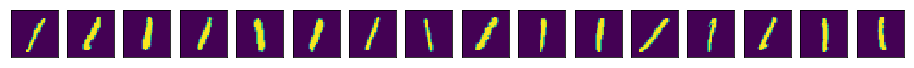

In [10]:
plot_digits(mnist_1, title="MNIST Class 1")

In [11]:
fmnist_1 = get_data_for_class('fashion-mnist', 1)
fmnist_1_all = get_data_for_class('fashion-mnist', 1, no=None)

fmnist_anker_boots = get_data_for_class('fashion-mnist', 9, seed=7)
fmnist_anker_boots_all = get_data_for_class('fashion-mnist', 9, no=None)

In [12]:
fmnist_1_all.shape

(1000, 28, 28)

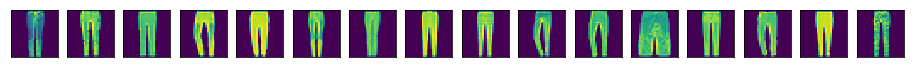

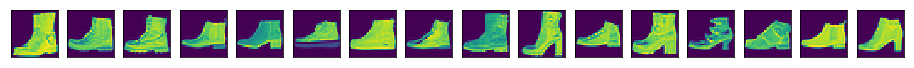

In [13]:
plot_digits(fmnist_1, 'Fashion MNIST-1')
plot_digits(fmnist_anker_boots, 'Fashion MNIST-9')


In [14]:
def plot_relevance(network, seq, dataset_name, data, method='lrp_deep_taylor'):
    path = model_path(network, dataset_name, seq)
    m = provider.load(path)
    _, heatmaps = getattr(m, 'rel_%s' % method)(data)
    plot_digits(heatmaps, title='%s : %s' % (method, m._.experiment_name), show_title=True)

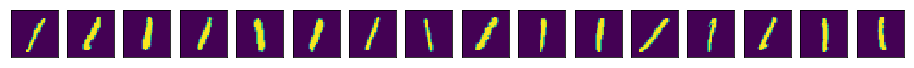

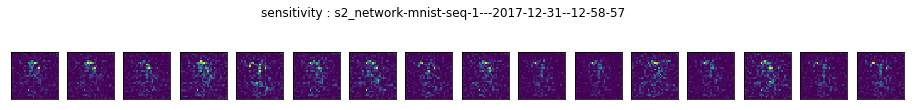

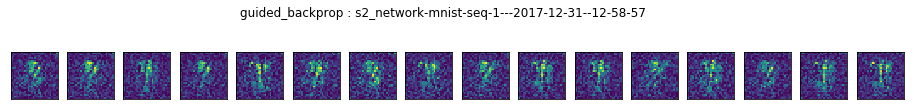

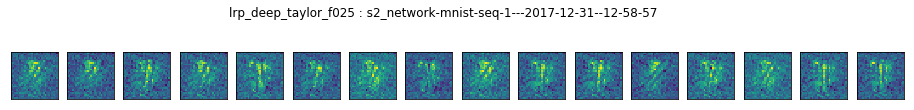

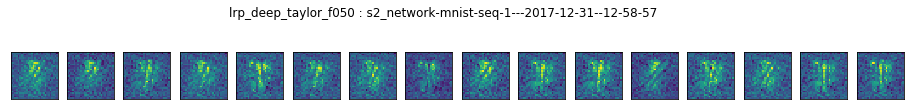

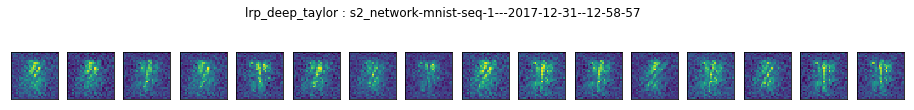

In [15]:
def plot_relevance_all(network, seq, dataset, data_obj):
    plot_digits(data_obj)
    for m in ['sensitivity', 'guided_backprop', 'lrp_deep_taylor_f025', 'lrp_deep_taylor_f050', 'lrp_deep_taylor']:
        plot_relevance(network, seq, dataset, data_obj, method=m)

plot_relevance_all('s2', 1, 'mnist', mnist_1)

## Shallow

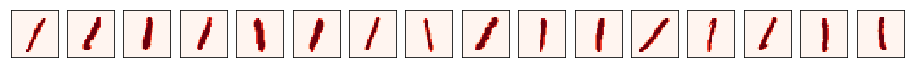

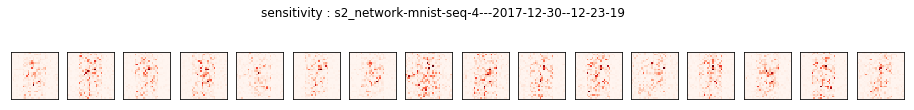

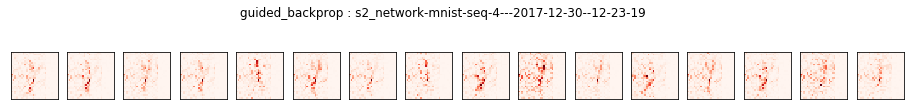

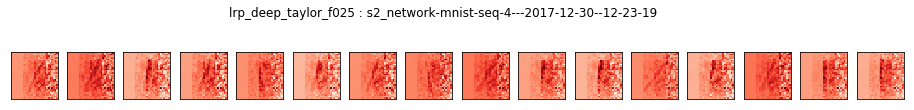

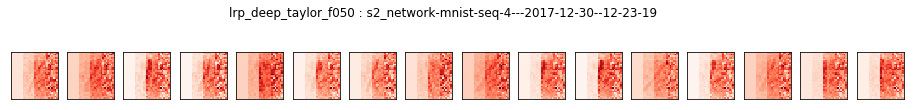

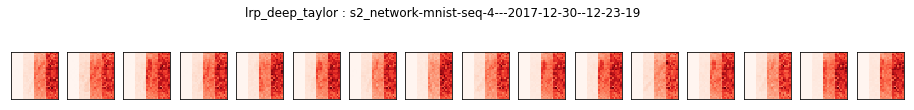

In [42]:
plot_relevance_all('s2', 4, 'mnist', mnist_1)

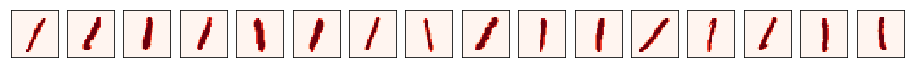

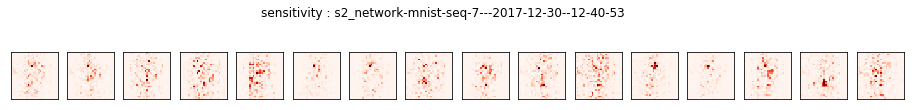

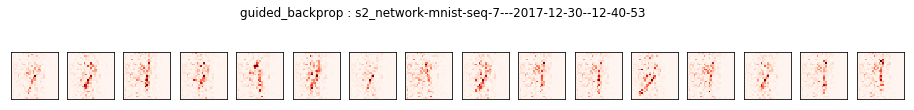

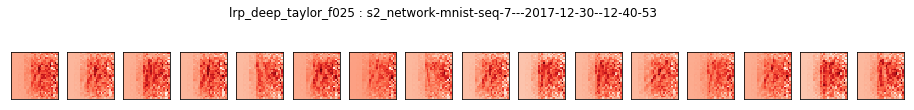

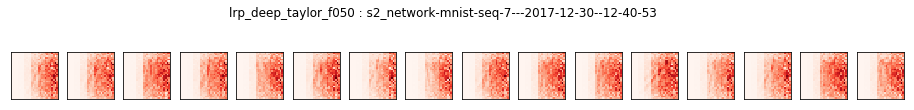

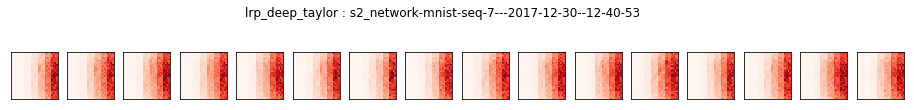

In [89]:
plot_relevance_all('s2', 7, 'mnist', mnist_1)

## Deep

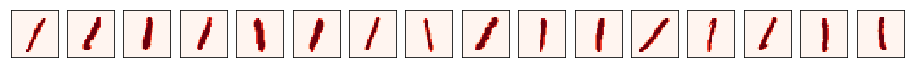

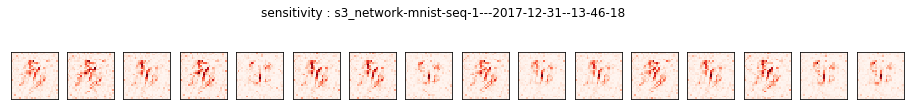

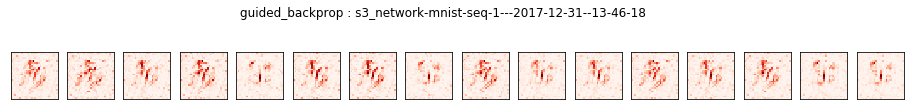

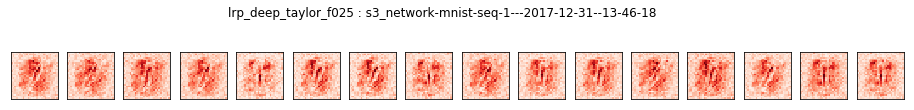

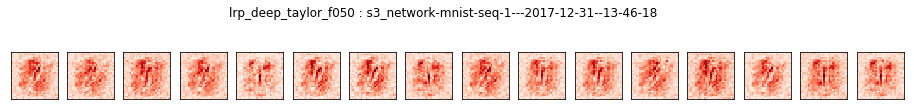

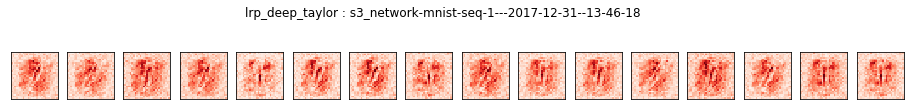

In [16]:
plot_relevance_all('s3', 1, 'mnist', mnist_1)

## DeepV2

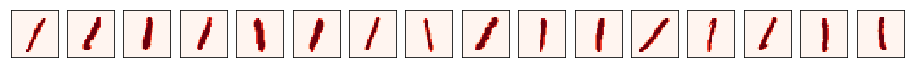

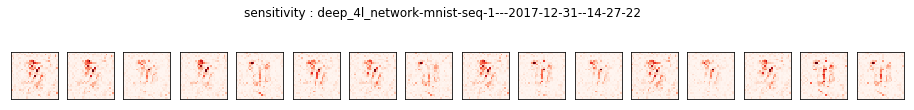

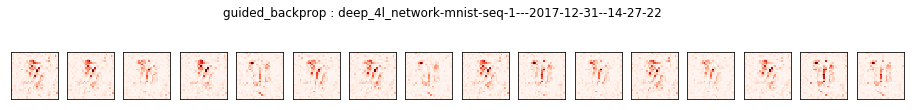

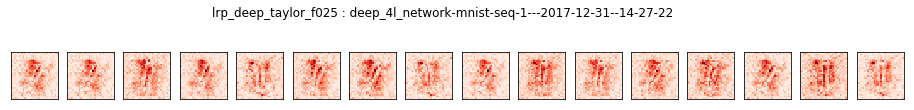

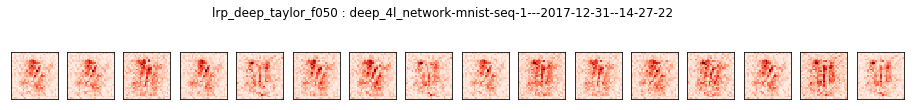

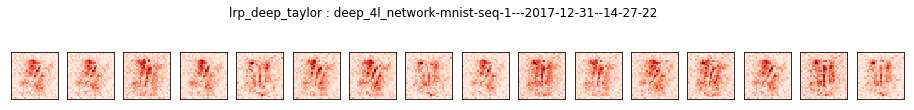

In [17]:
plot_relevance_all('deep_4l', 1, 'mnist', mnist_1)

## ConvDeep

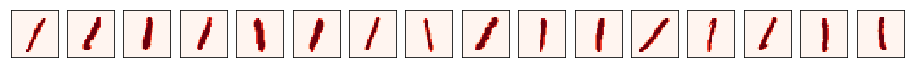

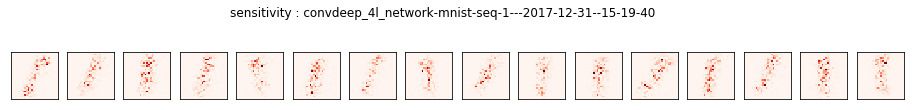

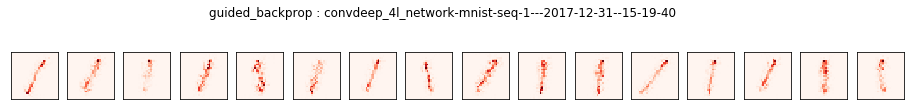

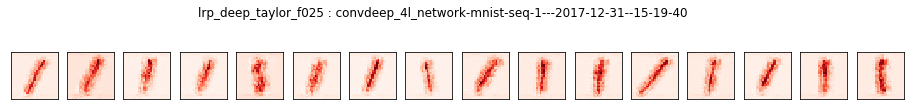

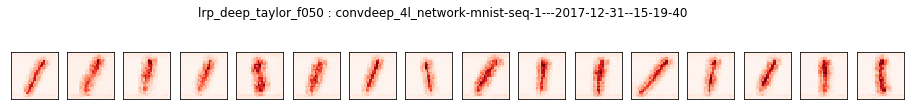

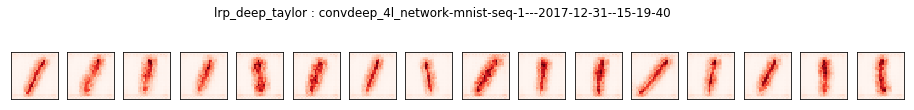

In [18]:
plot_relevance_all('convdeep_4l', 1, 'mnist', mnist_1)

## FashionMNIST

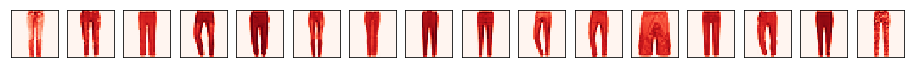

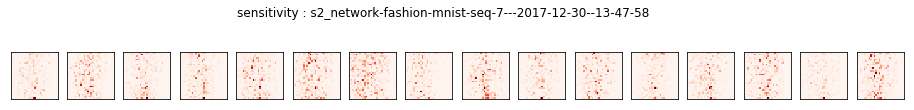

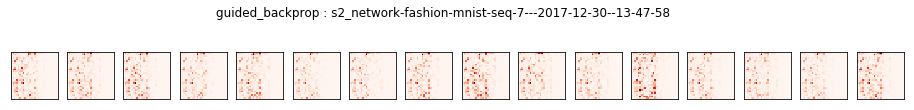

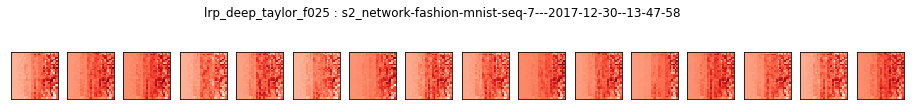

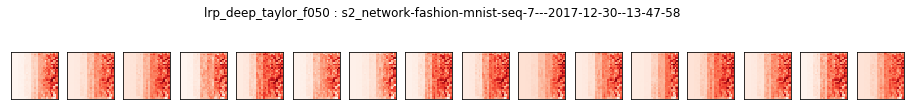

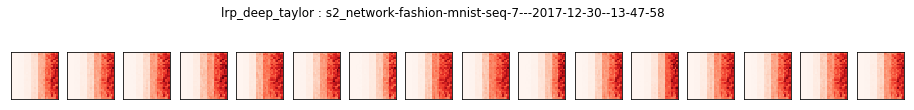

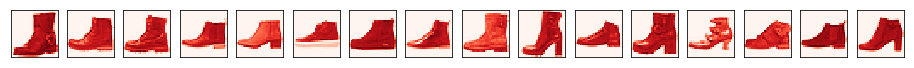

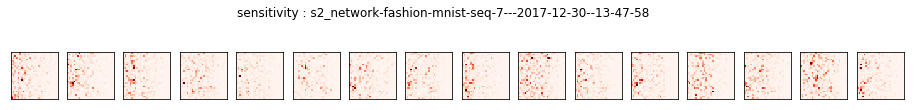

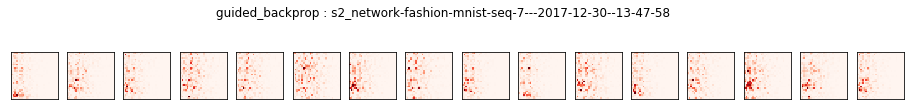

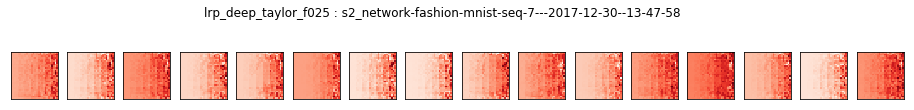

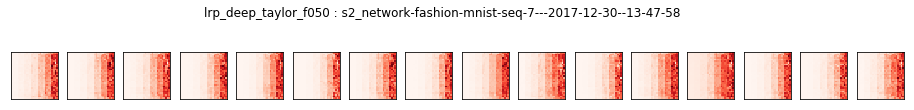

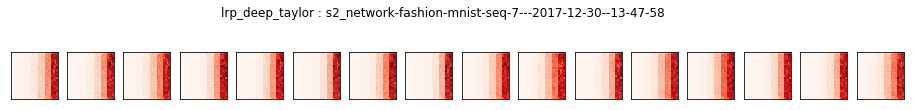

In [19]:
plot_relevance_all('s2', 7, 'fashion-mnist', fmnist_1)
plot_relevance_all('s2', 7, 'fashion-mnist', fmnist_anker_boots)

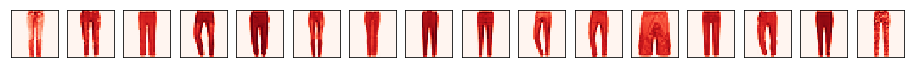

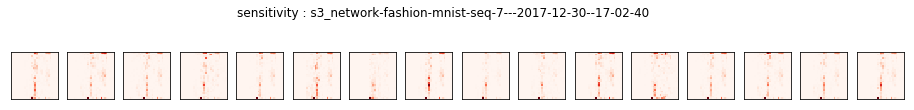

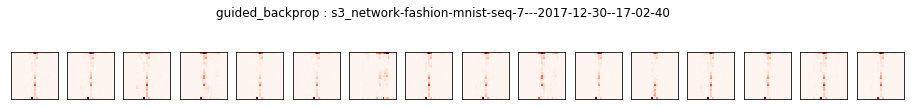

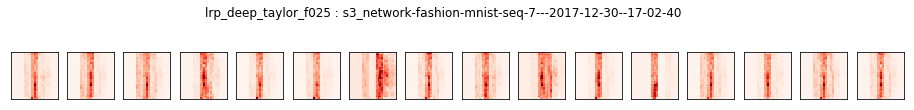

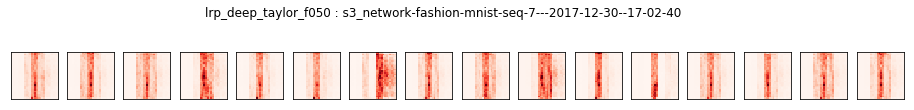

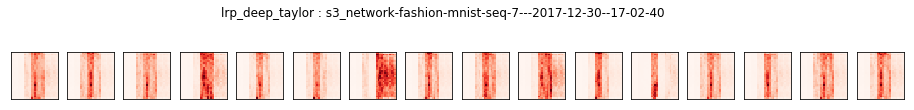

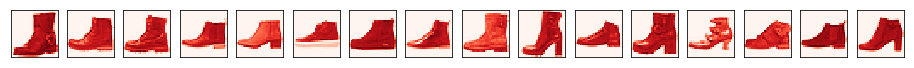

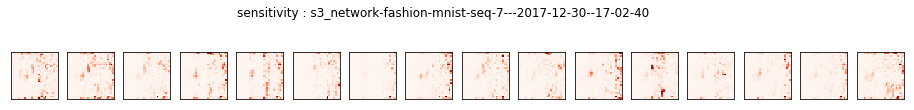

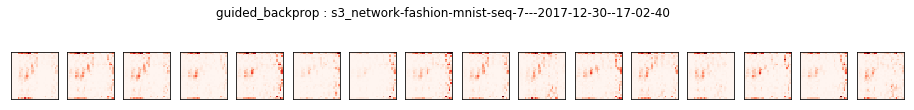

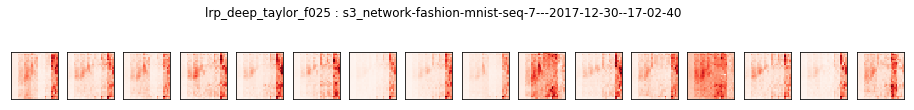

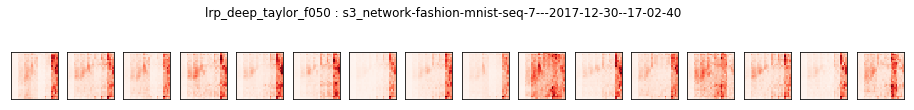

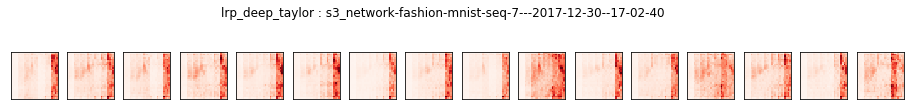

In [20]:
plot_relevance_all('s3', 7, 'fashion-mnist', fmnist_1)
plot_relevance_all('s3', 7, 'fashion-mnist', fmnist_anker_boots)

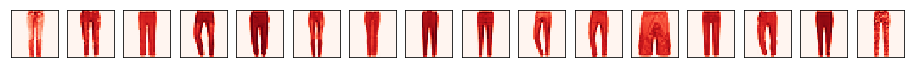

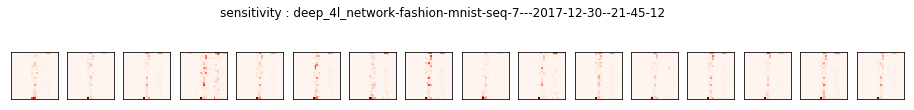

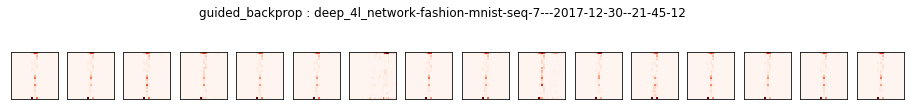

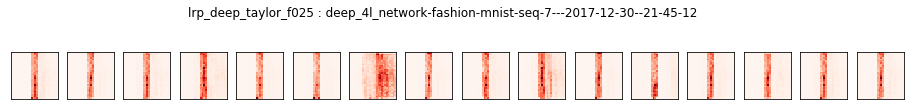

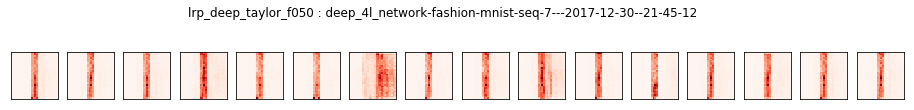

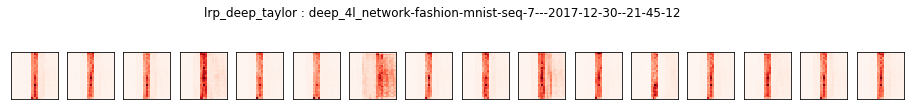

In [21]:
plot_relevance_all('deep_4l', 7, 'fashion-mnist', fmnist_1)

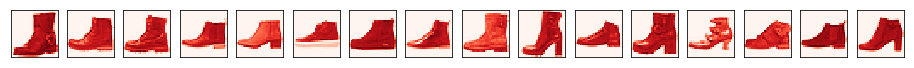

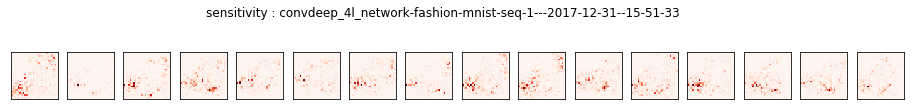

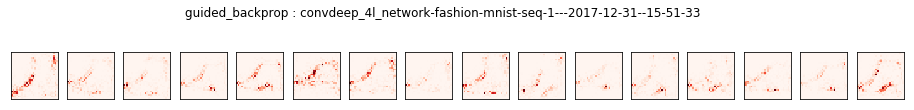

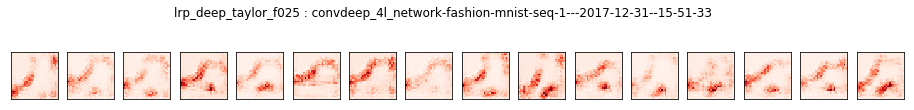

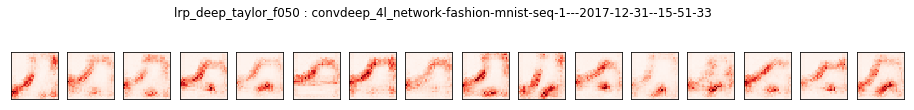

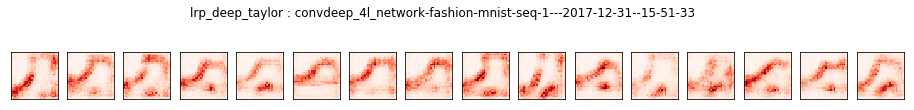

In [41]:
plot_relevance_all('convdeep_4l', 1, 'fashion-mnist', fmnist_anker_boots)

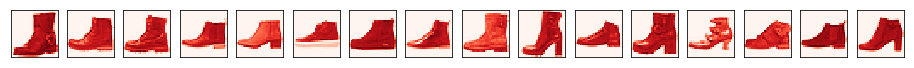

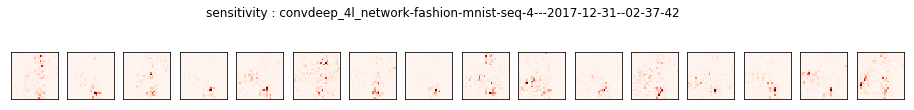

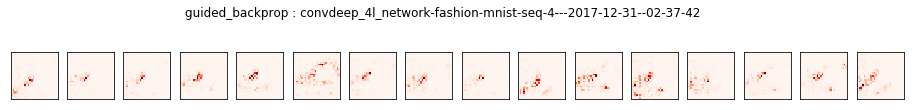

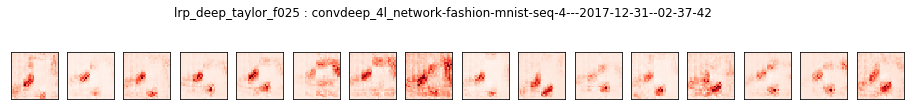

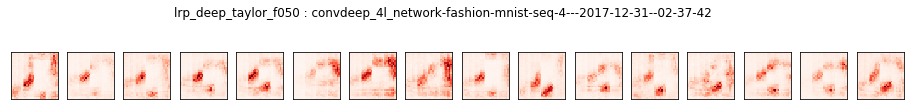

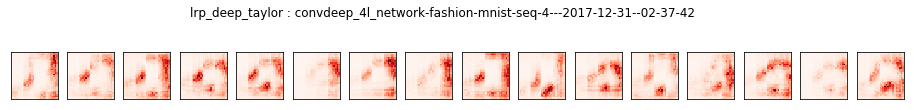

In [40]:
plot_relevance_all('convdeep_4l', 4, 'fashion-mnist', fmnist_anker_boots)

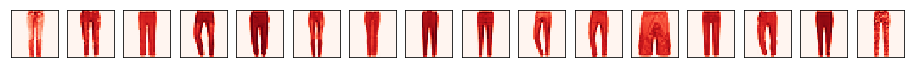

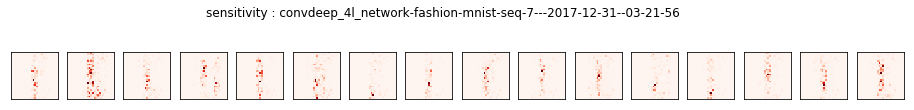

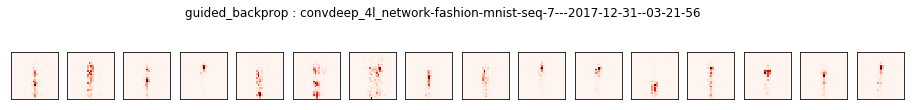

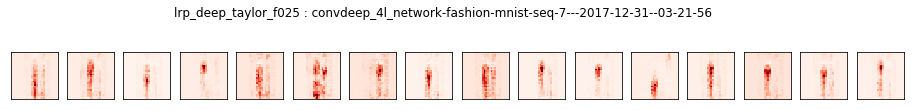

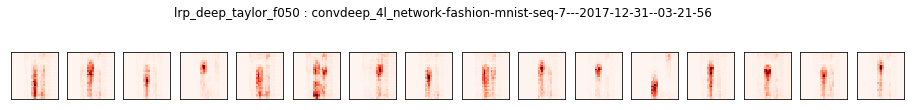

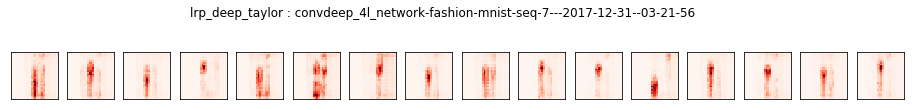

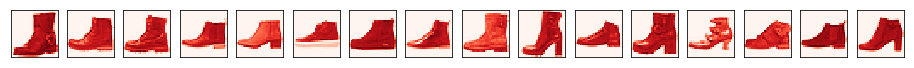

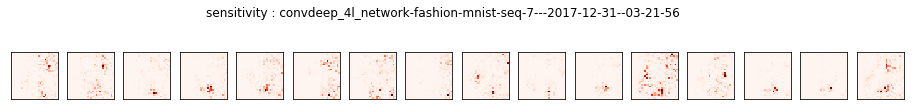

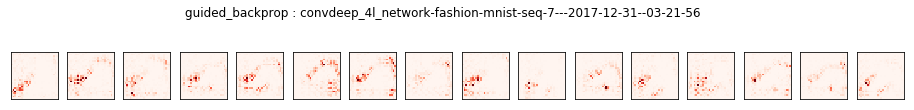

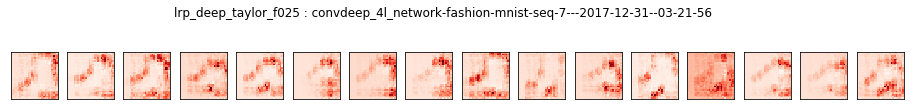

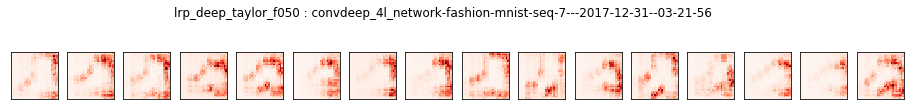

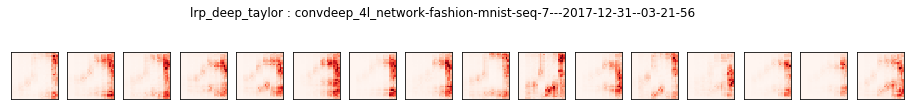

In [22]:
plot_relevance_all('convdeep_4l', 7, 'fashion-mnist', fmnist_1)
plot_relevance_all('convdeep_4l', 7, 'fashion-mnist', fmnist_anker_boots)

# Plot distribution

In [64]:
def compute_distribution(data, seq):
    dist = np.zeros(seq)

    dmin = np.min(data)
    dmax = np.max(data)
    normalized = (data - dmin)/(dmax-dmin)
    no_cols_feed = int(data.shape[2]/seq)
    xaxis = []
    for i in range(0, data.shape[2], no_cols_feed):
        st, end = i, i+no_cols_feed
        step = int(i/no_cols_feed)

        dist[step] = np.sum(normalized[:, :, st:end])
        
    return dist / np.sum(dist)

def compute_entropy_dist(data, seq):

    dmin = np.min(data)
    dmax = np.max(data)

    no_cols_feed = int(data.shape[2]/seq)
    xaxis = []
    entropies = np.zeros((data.shape[0], seq))
    for i in range(0, data.shape[2], no_cols_feed):
        st, end = i, i+no_cols_feed
        
        step = int(i/no_cols_feed)

        count, _ = np.histogram(data[:, :, st:end], bins=100, range=(dmin,dmax))
        
        prob = count / np.sum(count)
        indices = np.where(prob > 0)
        
        prob = prob[indices]
        
        lprob = np.log2(prob)
        entropies[:, step] = -np.sum(prob*lprob)
        
    if seq > 1:
        sum_ent = np.sum(entropies, axis=1)
        normed_entropies = entropies / sum_ent.reshape(-1,1)
        agg_entropies = np.sum(normed_entropies, axis=0)
        dist_ent = agg_entropies / np.sum(agg_entropies)

    else:
        print('not noramlize entropy because seq=%d' % seq)
        normed_entropies = entropies
        dist_ent = np.mean(normed_entropies)
        print('%f' % dist_ent)

    return dist_ent

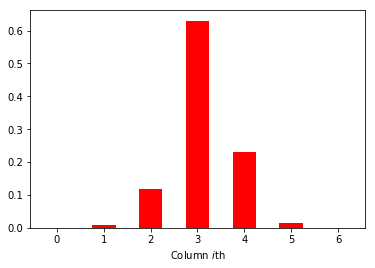

In [24]:
def plot_dist(data, seq, title=""):
    dist = np.zeros(seq)

    dmin = np.min(data)
    dmax = np.max(data)
    normalized = (data - dmin)/(dmax-dmin)
    no_cols_feed = int(data.shape[2]/seq)
    xaxis = []
    for i in range(0, data.shape[2], no_cols_feed):
        st, end = i, i+no_cols_feed
        step = int(i/no_cols_feed)

        dist[step] = np.sum(normalized[:, :, st:end])

        xaxis.append('%d:%d' %(st+1, end))
    plt.bar(range(seq), dist / np.sum(dist), 0.5, color='r')
#     plt.xticks(range(seq), xaxis)
    plt.xlabel('Column $i$th')
    plt.title(title)
    plt.show()
plot_dist(mnist_1, 7)

In [25]:
def plot_rel_dist(network, data, dataset_name, seq):
    path = model_path(network, dataset_name, seq)
    m = provider.load(path)
    _, heatmaps = m.rel_lrp_deep_taylor(data)
    plot_dist(heatmaps, seq, title='Rel Dist of %s' % m._.experiment_name)

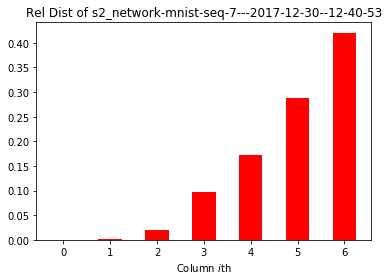

In [26]:
plot_rel_dist('s2', mnist_1, 'mnist', 7)

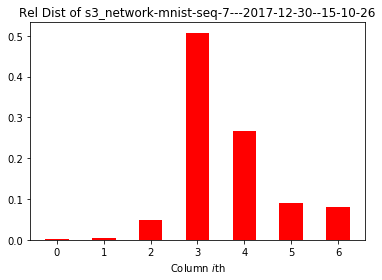

In [27]:
plot_rel_dist('s3', mnist_1, 'mnist', 7)

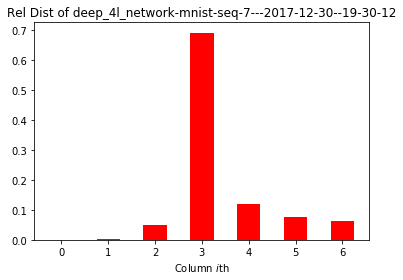

In [28]:
plot_rel_dist('deep_4l', mnist_1, 'mnist', 7)

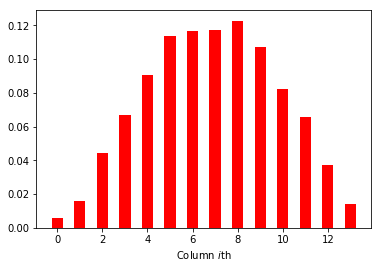

In [29]:
plot_dist(dataset['fashion-mnist'].test2d.x, 14)

In [86]:
def plot_distributions(networks, dataset_name, data, seq, method='lrp_deep_taylor', data_label="Data", dist_entropy=False):
    if dist_entropy:
        dist_data = compute_entropy_dist(data, seq)
    else:
        dist_data = compute_distribution(data, seq)
    plt.plot(dist_data, '--', label=data_label, marker='o')
    for i in networks:
        path = model_path(i, dataset_name, seq)
        m = provider.load(path)
        _, heatmaps = getattr(m, 'rel_%s' % method)(data)
        if dist_entropy:
            dist_hm = compute_entropy_dist(heatmaps, seq)
        else:
            dist_hm = compute_distribution(heatmaps, seq)
        plt.plot(dist_hm, label="%s" % m.formal_name(), marker='*')
    if dist_entropy:
        plt.ylabel('Relative Entropy Distribution')
    else:
        plt.ylabel('Distribution')
    plt.xlabel('Step $i^{th}$')
    plt.yticks(np.arange(0,1.1, 0.2))

    plt.xticks(range(seq), range(1, seq+1))
    plt.title('Explained by %s' % method)
    plt.legend()
    plt.show()
    
def plot_dist_with_methods(networks, dataset_name, data, seq, data_label="Data", dist_entropy=False):
    for m in ['guided_backprop', 'lrp_deep_taylor']:
        plot_distributions(networks, dataset_name, data, seq, method=m, data_label=data_label, dist_entropy=dist_entropy)

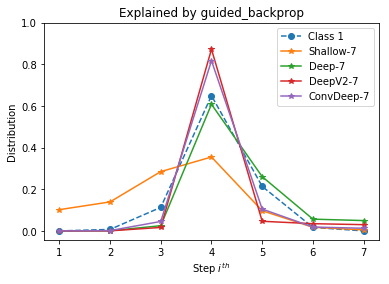

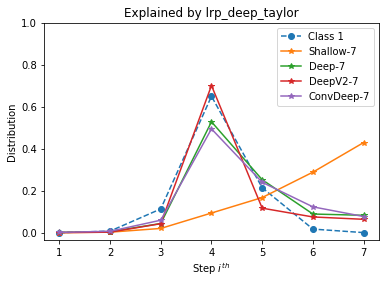

In [80]:
plot_dist_with_methods(['s2', 's3', 'deep_4l', 'convdeep_4l'], 'mnist', mnist_1_all, 7, data_label="Class 1", dist_entropy=False)

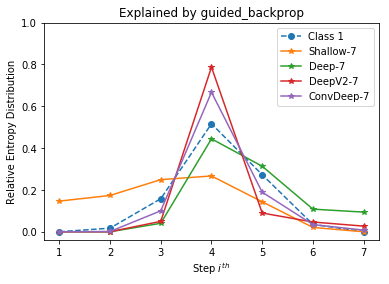

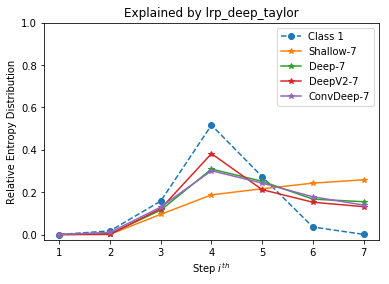

In [87]:
plot_dist_with_methods(['s2', 's3', 'deep_4l', 'convdeep_4l'], 'mnist', mnist_1_all, 7, data_label="Class 1", dist_entropy=True)

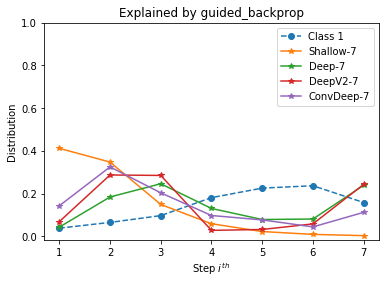

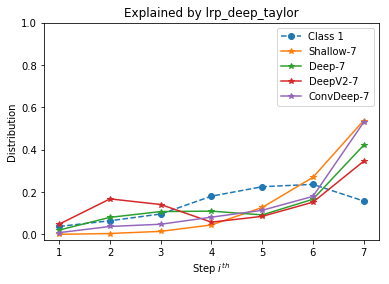

In [84]:
plot_dist_with_methods(['s2', 's3','deep_4l', 'convdeep_4l'], 'fashion-mnist', fmnist_anker_boots, 7, data_label="Class 1", dist_entropy=False)

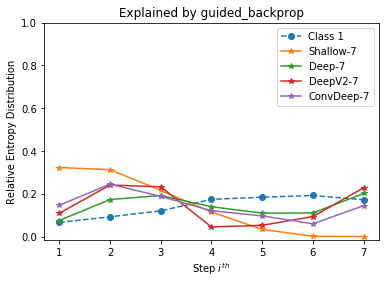

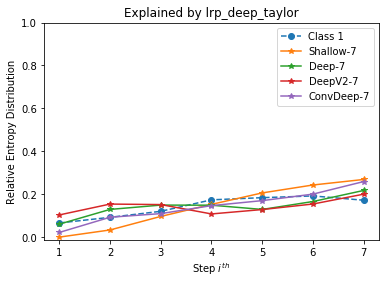

In [88]:
plot_dist_with_methods(['s2', 's3', 'deep_4l', 'convdeep_4l'], 'fashion-mnist', fmnist_anker_boots, 7, data_label="Class 1", dist_entropy=True)